# TRAINING SESSION 2 - ViTl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
import random
import h5py
import gc
from accelerate import Accelerator
from accelerate.utils import set_seed
from accelerate import notebook_launcher
from accelerate import DistributedDataParallelKwargs

import transformers

import torch
import torchvision
from torchvision.transforms import v2
from torchvision.transforms import Compose
import torch.nn.functional as F
import albumentations as A

from depth_anything_v2.dpt import DepthAnythingV2
from util.loss import SiLogLoss
from dataset.transform import Resize, NormalizeImage, PrepareForNet, Crop

import json
from pathlib import Path
import struct
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from dataclasses import dataclass
from typing import Tuple
import pandas as pd
import seaborn as sns


## Helper Functions

In [ ]:

# Read Depth as PFM file
def read_pfm(filename):
    with Path(filename).open('rb') as pfm_file:

        line1, line2, line3 = (pfm_file.readline().decode('latin-1').strip() for _ in range(3))
        assert line1 in ('PF', 'Pf')
        
        channels = 3 if "PF" in line1 else 1
        width, height = (int(s) for s in line2.split())
        scale_endianess = float(line3)
        bigendian = scale_endianess > 0
        scale = abs(scale_endianess)

        buffer = pfm_file.read()
        samples = width * height * channels
        assert len(buffer) == samples * 4
        
        fmt = f'{"<>"[bigendian]}{samples}f'
        decoded = struct.unpack(fmt, buffer)
        shape = (height, width, 3) if channels == 3 else (height, width)
        return np.flipud(np.reshape(decoded, shape)) * scale
    
def read_depths(depth_file_path):
    
    filename = depth_file_path.split("/")[-1]
    # InSpaceType
    if filename.endswith(".pfm"):
        depth_pfm = read_pfm(depth_file_path)
        invalid_mask = np.where(depth_pfm == np.inf)
        depth_pfm[invalid_mask] = 0
        # Also set values above 19.0 to 0 to reduce noise
        depth_pfm[depth_pfm > 19.0] = 0
        depth = depth_pfm
    
    elif filename.endswith(".npy"):
        depth = np.load(depth_file_path)
    elif filename.endswith(".tiff"):
        depth = cv2.imread(depth_file_path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    return depth

def read_images(image_file_path):
    
    filename = image_file_path.split("/")[-1]

    if filename.endswith(".png"):
        image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif filename.endswith(".jpg"):
        image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return image

def reduce_dataset(dataset, reduction_factor=0.9, seed=42):
    """
    Reduces the dataset by the specified reduction factor.
    Keeps (1 - reduction_factor) percentage of the data.
    """
    num_samples = len(dataset)
    reduced_size = int(num_samples * (1 - reduction_factor))
    random.seed(seed)
    indices = random.sample(range(num_samples), reduced_size)
    return Subset(dataset, indices)

## Setup Training and Validation Paths
training_jsons_path = "/media/navvis/Extreme Pro/MDE-TRAINING-CODE/mde-training/Depth-Anything-V2/training-jsons/Training3-LoadRunner/"

no_check_list =  ['train_data.json', 'test_data.json', 'combined_train.json']
# Load all JSON files
json_files = [file for file in os.listdir(training_jsons_path) if file.endswith(".json") and file not in no_check_list]

# Combine all RGB and DEPTH paths
combined_data = {"RGB": [], "DEPTH": []}

for file in json_files:
    with open(f"{training_jsons_path}{file}", "r") as f:
        data = json.load(f)
        combined_data["RGB"].extend(data["RGB"])
        combined_data["DEPTH"].extend(data["DEPTH"])

# Save combined data to a JSON file for future use (optional)
combined_json_path = f"{training_jsons_path}combined_train.json"
with open(combined_json_path, "w") as f:
    json.dump(combined_data, f, indent=4)

print(f"Combined JSON saved at {combined_json_path}")
print(f"Total number of samples: {len(combined_data['RGB'])}")


## Split Train-Test
# Define the split ratio
train_ratio = 0.95  # Training - Testing

# Split the data
rgb_train, rgb_test, depth_train, depth_test = train_test_split(
    combined_data["RGB"], combined_data["DEPTH"], test_size=1-train_ratio, random_state=42
)

# Create the training and testing JSON structures
train_data = {"RGB": rgb_train, "DEPTH": depth_train}
test_data = {"RGB": rgb_test, "DEPTH": depth_test}

# Save training and testing JSONs
train_json_path = f"{training_jsons_path}train_data.json"
test_json_path = f"{training_jsons_path}test_data.json"


    
with open(train_json_path, "w") as f:
    json.dump(train_data, f, indent=4)
with open(test_json_path, "w") as f:
    json.dump(test_data, f, indent=4)

print(f"Training JSON saved at {train_json_path}")
print(f"Testing JSON saved at {test_json_path}")
print(f"Training samples: {len(train_data['RGB'])}")
print(f"Testing samples: {len(test_data['RGB'])}")
## Load Dataset

@dataclass
class DataConfig:
    train_json_path: str
    test_json_path: str
    size: Tuple[int, int] = (518, 518)  # Default size for resizing

    def load_data(self):
        # Load train and test data from JSON files
        with open(self.train_json_path, "r") as f:
            train_data = json.load(f)
        with open(self.test_json_path, "r") as f:
            test_data = json.load(f)
        return train_data, test_data
## Custom Dataset Class
class CustomDepthDataset(torch.utils.data.Dataset):
    def __init__(self, data, mode, size=(518, 518)):
        """
        Initialize the dataset.
        :param data: A dictionary with "RGB" and "DEPTH" keys containing file paths.
        :param mode: 'train' or 'val'
        :param size: Tuple (width, height) for resizing images.
        """
        self.mode = mode  # train or val
        self.size = size
        self.rgb_paths = data["RGB"]
        self.depth_paths = data["DEPTH"]

        net_w, net_h = size
        # Define transforms (same logic as NYU class)
        self.transform = Compose([
            Resize(
                width=net_w,
                height=net_h,
                resize_target=True if mode == 'train' else False,
                keep_aspect_ratio=False, # Dataset contains images with different aspect ratios
                ensure_multiple_of=14,
                resize_method='lower_bound',
                image_interpolation_method=cv2.INTER_CUBIC,
            ),
            # ImageNet mean and std normalization
            NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            PrepareForNet(),
        ] + ([Crop(size[0])] if self.mode == 'train' else []))

        # Augmentations for training only
        self.augs = A.Compose([
            A.HorizontalFlip(),
            A.ColorJitter(hue=0.1, contrast=0.1, brightness=0.1, saturation=0.1, p=0.2),
            A.GaussNoise(var_limit=25, p=0.2),
        ])

    def __getitem__(self, index):
        rgb_path = self.rgb_paths[index]
        depth_path = self.depth_paths[index]

        # Load RGB and depth images
        rgb = self.load_rgb(rgb_path)
        depth = self.load_depth(depth_path)

        # Resize to target size
        rgb = cv2.resize(rgb, self.size, interpolation=cv2.INTER_AREA)
        depth = cv2.resize(depth, self.size, interpolation=cv2.INTER_NEAREST)

        if self.mode == 'train':
            # Apply augmentations
            augmented = self.augs(image=rgb, mask=depth)
            rgb = augmented["image"] / 255.0
            depth = augmented["mask"]
        else:
            rgb = rgb / 255.0

        # Apply transforms
        sample = self.transform({'image': rgb, 'depth': depth})
        sample['image'] = torch.from_numpy(sample['image'])
        sample['depth'] = torch.from_numpy(sample['depth'])

        return sample

   

    def __len__(self):
        return len(self.rgb_paths)

    # TODO: Depth Validation can be Done here
    def load_rgb(self, path):
        # Use custom `read_images` function
        return read_images(path)

    def load_depth(self, path):
        # Use custom `read_depths` function
        return read_depths(path)
## Initialize the Dataset for View

# Initialize config
config = DataConfig(
    train_json_path=f"{training_jsons_path}train_data.json",
    test_json_path=f"{training_jsons_path}test_data.json",
    size=(518, 518),
)

# Load data
train_data, test_data = config.load_data()

# Initialize datasets
train_dataset = CustomDepthDataset(train_data, mode='train', size=config.size)
test_dataset = CustomDepthDataset(test_data, mode='val', size=config.size)


# Initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)



print(f"Train loader has {len(train_loader)} batches.")
print(f"Test loader has {len(test_loader)} batches.")
## Show some Data Random
def visualize_samples(train_dataset, test_dataset, N=5, M=5):
    """
    Visualize N random training samples and M random test samples.
    :param train_dataset: PyTorch Dataset for training data.
    :param test_dataset: PyTorch Dataset for test data.
    :param N: Number of training samples to visualize.
    :param M: Number of test samples to visualize.
    """
    # Helper to denormalize RGB images
    def denormalize(image):
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        image = image * std + mean  # Undo normalization
        return (image * 255).astype('uint8')  # Scale to 0-255 range

    # Visualize training samples
    print(f"Visualizing {N} random training samples...")
    fig, axes = plt.subplots(N, 2, figsize=(10, 5 * N))
    for i in range(N):
        idx = random.randint(0, len(train_dataset) - 1)
        sample = train_dataset[idx]
        rgb = denormalize(sample['image'].numpy().transpose(1, 2, 0))  # HWC format
        depth = sample['depth'].numpy()

        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"Train RGB Sample {idx}")
        axes[i, 0].axis('off')

        depth_im = axes[i, 1].imshow(depth, cmap='inferno')
        axes[i, 1].set_title(f"Train Depth Sample {idx}")
        axes[i, 1].axis('off')
        fig.colorbar(depth_im, ax=axes[i, 1], orientation='vertical')

    plt.tight_layout()
    plt.show()

    # Visualize test samples
    print(f"Visualizing {M} random test samples...")
    fig, axes = plt.subplots(M, 2, figsize=(10, 5 * M))
    for i in range(M):
        idx = random.randint(0, len(test_dataset) - 1)
        sample = test_dataset[idx]
        rgb = denormalize(sample['image'].numpy().transpose(1, 2, 0))  # HWC format
        depth = sample['depth'].numpy()

        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"Test RGB Sample {idx}")
        axes[i, 0].axis('off')

        depth_im = axes[i, 1].imshow(depth, cmap='inferno')
        axes[i, 1].set_title(f"Test Depth Sample {idx}")
        axes[i, 1].axis('off')
        fig.colorbar(depth_im, ax=axes[i, 1], orientation='vertical')

    plt.tight_layout()
    plt.show()

# Call the function to visualize samples
visualize_samples(train_dataset, test_dataset, N=3, M=3)

## Metrics Function

In [ ]:
def eval_depth(pred, target):
    """
    Evaluate depth predictions against ground truth with various metrics.
    
    :param pred: Predicted depth map (torch.Tensor).
    :param target: Ground truth depth map (torch.Tensor).
    :return: Dictionary of evaluation metrics.
    """
    assert pred.shape == target.shape, "Predicted and target depth maps must have the same shape."

    # Calculate threshold
    thresh = torch.max(target / pred, pred / target)

    # Accuracy under thresholds
    d1 = torch.sum(thresh < 1.25).float() / len(thresh)
    d2 = torch.sum(thresh < 1.25 ** 2).float() / len(thresh)
    d3 = torch.sum(thresh < 1.25 ** 3).float() / len(thresh)

    # Differences
    diff = pred - target
    diff_log = torch.log(pred) - torch.log(target)

    # Error metrics
    abs_rel = torch.mean(torch.abs(diff) / target)  # Absolute Relative Difference
    sq_rel = torch.mean(torch.pow(diff, 2) / target)  # Squared Relative Difference
    rmse = torch.sqrt(torch.mean(torch.pow(diff, 2)))  # Root Mean Square Error
    mae = torch.mean(torch.abs(diff))  # Mean Absolute Error
    silog = torch.sqrt(torch.pow(diff_log, 2).mean() - 0.5 * torch.pow(diff_log.mean(), 2))  # Scale-Invariant Log
    rmse_log = torch.sqrt(torch.mean(torch.pow(diff_log, 2)))  # RMSE of log differences
    log10 = torch.mean(torch.abs(torch.log10(pred) - torch.log10(target)))  # Log10 error


    # Return all metrics in a dictionary
    return {
        'd1': d1,
        'd2': d2,
        'd3': d3,
        'abs_rel': abs_rel,
        'sq_rel': sq_rel,
        'rmse': rmse,
        'mae': mae,
        'silog': silog,
        'rmse_log': rmse_log,
        'log10': log10,
    }


## Setup Parameters

In [ ]:
## Training Parameter Setup
model_weights_path = '/media/navvis/Extreme Pro/MDE-TRAINING-CODE/mde-training/Depth-Anything-V2/checkpoints/depth_anything_v2_metric_vkitti_vitl.pth' 
model_configs = {
        'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
        'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
        'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
        'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
    }
model_encoder = 'vitl'
max_depth = 80.0
batch_size = 6
lr = 5e-6
weight_decay = 0.01
num_epochs = 56
warmup_epochs = 6.0
scheduler_rate = 1
load_state = False

DATASET = 'custom-trainingv4-ViTb'
MODEL_ID = f'{model_encoder}_{lr}_{weight_decay}_epochs{num_epochs}'


state_path = "/media/navvis/Extreme Pro/MDE-TRAINING-CODE/mde-training/Depth-Anything-V2/T-States/"
save_model_path = f'/media/navvis/Extreme Pro/MDE-TRAINING-CODE/mde-training/Depth-Anything-V2/Trained_Checkpoints/{DATASET}_{MODEL_ID}.pth' 
seed = 42
mixed_precision = 'fp16'

## Logging

In [ ]:
def save_epoch_metrics_csv(epoch_results, filepath):
    """
    Append single epoch metrics to CSV file
    Args:
        epoch_results (dict): Dictionary containing metrics for current epoch
        filepath (str): Path to save the CSV file
    """
    # Convert the epoch results to a pandas DataFrame (single row)
    df_row = pd.DataFrame([epoch_results])
    
    # If file doesn't exist, write with header. If exists, append without header
    df_row.to_csv(filepath, 
                  mode='a',  # append mode
                  header=not os.path.exists(filepath),  # only write header if file doesn't exist
                  index=False)
    
output_path = f"/media/navvis/Extreme Pro/MDE-TRAINING-CODE/mde-training/Depth-Anything-V2/Trained_Checkpoints/{DATASET}_{MODEL_ID}_log.csv"

## Training Loop

In [ ]:


def train_fn():

    set_seed(seed)
    ddp_kwargs = DistributedDataParallelKwargs(find_unused_parameters=True) # need for freezing layers with DDP
    accelerator = Accelerator(mixed_precision=mixed_precision, 
                              kwargs_handlers=[ddp_kwargs],
                             )
    
    # in the paper they initialize decoder randomly and use only encoder pretrained weights. Then full fine-tune
    # ViT-S encoder here
    model = DepthAnythingV2(**{**model_configs[model_encoder], 'max_depth': max_depth})
    model.load_state_dict({k: v for k, v in torch.load(model_weights_path).items() if 'pretrained' in k}, strict=False)
    
    optim = torch.optim.AdamW([{'params': [param for name, param in model.named_parameters() if 'pretrained' in name], 'lr': lr},
                       {'params': [param for name, param in model.named_parameters() if 'pretrained' not in name], 'lr': lr*10}],
                      lr=lr, weight_decay=weight_decay)
    
    criterion = SiLogLoss() # author's loss
#############################################################################################
    ## For Reduced Dataset
    # train_dataset_reduced = reduce_dataset(train_dataset, reduction_factor=0.95, seed=42)
    # test_dataset_reduced = reduce_dataset(test_dataset, reduction_factor=0.98, seed=42)

    # train_dataloader = DataLoader(train_dataset_reduced, batch_size=batch_size, shuffle=True, num_workers=4)
    # val_dataloader = DataLoader(test_dataset_reduced, batch_size=1, shuffle=False, num_workers=4)


    train_dataset = CustomDepthDataset(train_data, mode='train', size=config.size)
    test_dataset = CustomDepthDataset(test_data, mode='val', size=config.size)

    # Initialize dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
##############################################################################################

    # Print Amount of data for Training and Val
    print(f"Train loader has {len(train_dataloader)} batches with {len(train_dataloader)*batch_size} Samples.")
    print(f"Val loader has {len(val_dataloader)} batches with {len(val_dataloader)*1} Samples.")

    scheduler = transformers.get_cosine_schedule_with_warmup(optim, len(train_dataloader)*warmup_epochs, num_epochs*scheduler_rate*len(train_dataloader))
    
    model, optim, train_dataloader, val_dataloader, scheduler = accelerator.prepare(model, optim, train_dataloader, val_dataloader, scheduler)

    if load_state:
        accelerator.wait_for_everyone()
        accelerator.load_state(state_path)
        
    best_val_absrel = 1000


    for epoch in range(1, num_epochs):
        
        model.train()
        train_loss = 0
        for sample in tqdm(train_dataloader, disable = not accelerator.is_local_main_process):
            optim.zero_grad()
            
            img, depth = sample['image'], sample['depth']
            
            pred = model(img)                                                            
            loss = criterion(pred, depth, (depth <= max_depth) & (depth > 0))
            
            accelerator.backward(loss)
            optim.step()
            scheduler.step()
            
            train_loss += loss.detach()
            
        train_loss /= len(train_dataloader)
        train_loss = accelerator.reduce(train_loss, reduction='mean').item()

        model.eval()

        # Initialize results
        results = {k: torch.tensor(0.0, device=accelerator.device) for k in ['d1', 'abs_rel', 'rmse', 'mae', 'silog']}

        # Accumulate metrics
        for sample in tqdm(val_dataloader, disable=not accelerator.is_local_main_process):
            img, depth = sample['image'].float(), sample['depth'][0]
            with torch.no_grad():
                pred = model(img)
                pred = F.interpolate(pred[:, None], depth.shape[-2:], mode='bilinear', align_corners=True)[0, 0]
            valid_mask = (depth <= max_depth) & (depth > 0)
            


            cur_results = eval_depth(pred[valid_mask], depth[valid_mask])
            for k in results.keys():
                if not torch.isnan(cur_results[k]).any():
                    results[k] += cur_results[k]

           
        # Compute averages
        for k in results.keys():
            results[k] = results[k] / (len(val_dataloader))
            reduced_value = accelerator.reduce(results[k], reduction='mean')
            results[k] = round(reduced_value.item(), 3)
            
            
        accelerator.wait_for_everyone()
        accelerator.save_state(state_path, safe_serialization=False)
        
        if results['abs_rel'] < best_val_absrel:
            best_val_absrel = results['abs_rel']
            unwrapped_model = accelerator.unwrap_model(model)
            if accelerator.is_local_main_process:
                torch.save(unwrapped_model.state_dict(), save_model_path)
            if epoch == 15 or epoch == 20 or epoch == 25 or epoch == 40 or epoch == 45:
                torch.save(unwrapped_model.state_dict(), save_model_path.replace('.pth', f'_epoch{epoch}.pth'))
        
        accelerator.print(f"epoch_{epoch},  train_loss = {train_loss:.5f}, val_metrics = {results}")

        # Save the results of the epoch to a CSV file
        # 🚨 Logging Results - Training Results get Reset every epoch
        
        training_results = {'epoch': epoch, 'train_loss': train_loss, 'best_val_absrel': best_val_absrel, 'd1': results['d1'], 
                                   'abs_rel': results['abs_rel'], 'rmse': results['rmse'], 'mae': results['mae'], 
                                   'silog': results['silog']}
        save_epoch_metrics_csv(training_results, output_path)
        
        torch.cuda.empty_cache()
        gc.collect()



## Launch Training

In [ ]:
# Purge cuda memory and collect garbage
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
# Purge cuda memory and collect garbage
torch.cuda.empty_cache()
gc.collect()

# Allow exapandable segments
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
#You can run this code with 1 gpu. Just set num_processes=1
notebook_launcher(train_fn, num_processes=1)
# ignore the error. it's harmless
 

Launching training on one GPU.


/tmp/ipykernel_332964/2839372604.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict({k: v for k, v in torch.load(model_weights_path).items() if 'pret

Train loader has 8402 batches with 67216 Samples.
Val loader has 3538 batches with 3538 Samples.


100%|██████████| 3538/3538 [02:38<00:00, 22.32it/s]


epoch_1,  train_loss = 0.59896, val_metrics = {'d1': 0.467, 'abs_rel': 0.483, 'rmse': 2.498, 'mae': 1.685, 'silog': 0.367}


100%|██████████| 3538/3538 [02:39<00:00, 22.21it/s]


epoch_2,  train_loss = 0.40380, val_metrics = {'d1': 0.706, 'abs_rel': 0.268, 'rmse': 2.235, 'mae': 1.319, 'silog': 0.298}


100%|██████████| 3538/3538 [02:39<00:00, 22.21it/s]


epoch_3,  train_loss = 0.37059, val_metrics = {'d1': 0.706, 'abs_rel': 0.276, 'rmse': 2.033, 'mae': 1.205, 'silog': 0.291}


100%|██████████| 3538/3538 [02:38<00:00, 22.27it/s]


epoch_4,  train_loss = 0.35173, val_metrics = {'d1': 0.731, 'abs_rel': 0.271, 'rmse': 2.053, 'mae': 1.222, 'silog': 0.282}


100%|██████████| 3538/3538 [02:38<00:00, 22.29it/s]


epoch_5,  train_loss = 0.33888, val_metrics = {'d1': 0.619, 'abs_rel': 0.333, 'rmse': 2.036, 'mae': 1.312, 'silog': 0.296}


100%|██████████| 3538/3538 [02:39<00:00, 22.25it/s]


epoch_6,  train_loss = 0.33095, val_metrics = {'d1': 0.702, 'abs_rel': 0.303, 'rmse': 1.907, 'mae': 1.178, 'silog': 0.275}


100%|██████████| 3538/3538 [02:38<00:00, 22.30it/s]


epoch_7,  train_loss = 0.31961, val_metrics = {'d1': 0.757, 'abs_rel': 0.261, 'rmse': 1.838, 'mae': 1.091, 'silog': 0.262}


100%|██████████| 3538/3538 [02:39<00:00, 22.23it/s]


epoch_8,  train_loss = 0.30829, val_metrics = {'d1': 0.747, 'abs_rel': 0.293, 'rmse': 1.791, 'mae': 1.064, 'silog': 0.262}


100%|██████████| 3538/3538 [02:39<00:00, 22.18it/s]


epoch_9,  train_loss = 0.29775, val_metrics = {'d1': 0.797, 'abs_rel': 0.252, 'rmse': 1.736, 'mae': 1.011, 'silog': 0.25}


100%|██████████| 3538/3538 [02:38<00:00, 22.26it/s]


epoch_10,  train_loss = 0.28826, val_metrics = {'d1': 0.817, 'abs_rel': 0.219, 'rmse': 1.691, 'mae': 0.953, 'silog': 0.242}


100%|██████████| 3538/3538 [02:38<00:00, 22.32it/s]


epoch_11,  train_loss = 0.28126, val_metrics = {'d1': 0.823, 'abs_rel': 0.216, 'rmse': 1.739, 'mae': 0.973, 'silog': 0.241}


100%|██████████| 3538/3538 [02:38<00:00, 22.30it/s]


epoch_12,  train_loss = 0.27371, val_metrics = {'d1': 0.8, 'abs_rel': 0.235, 'rmse': 1.761, 'mae': 1.008, 'silog': 0.246}


100%|██████████| 3538/3538 [02:38<00:00, 22.26it/s]


epoch_13,  train_loss = 0.26490, val_metrics = {'d1': 0.822, 'abs_rel': 0.213, 'rmse': 1.739, 'mae': 0.97, 'silog': 0.239}


100%|██████████| 3538/3538 [02:38<00:00, 22.28it/s]


epoch_14,  train_loss = 0.25938, val_metrics = {'d1': 0.824, 'abs_rel': 0.219, 'rmse': 1.643, 'mae': 0.925, 'silog': 0.234}


100%|██████████| 3538/3538 [02:39<00:00, 22.25it/s]


epoch_15,  train_loss = 0.25246, val_metrics = {'d1': 0.825, 'abs_rel': 0.219, 'rmse': 1.676, 'mae': 0.949, 'silog': 0.236}


100%|██████████| 3538/3538 [02:39<00:00, 22.22it/s]


epoch_16,  train_loss = 0.24743, val_metrics = {'d1': 0.844, 'abs_rel': 0.211, 'rmse': 1.609, 'mae': 0.891, 'silog': 0.228}


100%|██████████| 3538/3538 [02:38<00:00, 22.28it/s]


epoch_17,  train_loss = 0.24218, val_metrics = {'d1': 0.849, 'abs_rel': 0.213, 'rmse': 1.577, 'mae': 0.872, 'silog': 0.225}


100%|██████████| 3538/3538 [02:39<00:00, 22.24it/s]


epoch_18,  train_loss = 0.23741, val_metrics = {'d1': 0.819, 'abs_rel': 0.214, 'rmse': 1.654, 'mae': 0.953, 'silog': 0.235}


100%|██████████| 3538/3538 [02:38<00:00, 22.27it/s]


epoch_19,  train_loss = 0.23195, val_metrics = {'d1': 0.838, 'abs_rel': 0.218, 'rmse': 1.595, 'mae': 0.907, 'silog': 0.23}


100%|██████████| 3538/3538 [02:38<00:00, 22.28it/s]


epoch_20,  train_loss = 0.22809, val_metrics = {'d1': 0.844, 'abs_rel': 0.199, 'rmse': 1.625, 'mae': 0.91, 'silog': 0.228}


100%|██████████| 3538/3538 [02:39<00:00, 22.25it/s]


epoch_21,  train_loss = 0.22438, val_metrics = {'d1': 0.849, 'abs_rel': 0.214, 'rmse': 1.582, 'mae': 0.883, 'silog': 0.225}


100%|██████████| 3538/3538 [02:39<00:00, 22.19it/s]


epoch_22,  train_loss = 0.21900, val_metrics = {'d1': 0.855, 'abs_rel': 0.21, 'rmse': 1.546, 'mae': 0.853, 'silog': 0.219}


100%|██████████| 3538/3538 [02:39<00:00, 22.17it/s]


epoch_23,  train_loss = 0.21622, val_metrics = {'d1': 0.851, 'abs_rel': 0.202, 'rmse': 1.609, 'mae': 0.887, 'silog': 0.223}


100%|██████████| 3538/3538 [02:38<00:00, 22.30it/s]


epoch_24,  train_loss = 0.21204, val_metrics = {'d1': 0.855, 'abs_rel': 0.184, 'rmse': 1.563, 'mae': 0.849, 'silog': 0.219}


100%|██████████| 3538/3538 [02:38<00:00, 22.31it/s]


epoch_25,  train_loss = 0.20795, val_metrics = {'d1': 0.863, 'abs_rel': 0.192, 'rmse': 1.502, 'mae': 0.811, 'silog': 0.215}


100%|██████████| 3538/3538 [02:39<00:00, 22.21it/s]


epoch_26,  train_loss = 0.20500, val_metrics = {'d1': 0.865, 'abs_rel': 0.187, 'rmse': 1.503, 'mae': 0.815, 'silog': 0.215}


100%|██████████| 3538/3538 [02:38<00:00, 22.27it/s]


epoch_27,  train_loss = 0.20251, val_metrics = {'d1': 0.867, 'abs_rel': 0.192, 'rmse': 1.51, 'mae': 0.809, 'silog': 0.214}


100%|██████████| 3538/3538 [02:38<00:00, 22.30it/s]


epoch_28,  train_loss = 0.19821, val_metrics = {'d1': 0.867, 'abs_rel': 0.192, 'rmse': 1.482, 'mae': 0.801, 'silog': 0.213}


100%|██████████| 3538/3538 [02:38<00:00, 22.27it/s]


epoch_29,  train_loss = 0.19562, val_metrics = {'d1': 0.869, 'abs_rel': 0.197, 'rmse': 1.472, 'mae': 0.796, 'silog': 0.211}


100%|██████████| 3538/3538 [02:39<00:00, 22.22it/s]


epoch_30,  train_loss = 0.19221, val_metrics = {'d1': 0.867, 'abs_rel': 0.19, 'rmse': 1.48, 'mae': 0.795, 'silog': 0.211}


100%|██████████| 3538/3538 [02:38<00:00, 22.32it/s]


epoch_31,  train_loss = 0.18970, val_metrics = {'d1': 0.873, 'abs_rel': 0.185, 'rmse': 1.448, 'mae': 0.774, 'silog': 0.209}


100%|██████████| 3538/3538 [02:38<00:00, 22.26it/s]


epoch_32,  train_loss = 0.18702, val_metrics = {'d1': 0.874, 'abs_rel': 0.187, 'rmse': 1.444, 'mae': 0.769, 'silog': 0.208}


100%|██████████| 3538/3538 [02:38<00:00, 22.28it/s]


epoch_33,  train_loss = 0.18426, val_metrics = {'d1': 0.874, 'abs_rel': 0.186, 'rmse': 1.442, 'mae': 0.769, 'silog': 0.207}


100%|██████████| 3538/3538 [02:39<00:00, 22.20it/s]


epoch_34,  train_loss = 0.18187, val_metrics = {'d1': 0.872, 'abs_rel': 0.183, 'rmse': 1.456, 'mae': 0.777, 'silog': 0.208}


100%|██████████| 3538/3538 [02:38<00:00, 22.27it/s]


epoch_35,  train_loss = 0.17973, val_metrics = {'d1': 0.876, 'abs_rel': 0.185, 'rmse': 1.433, 'mae': 0.761, 'silog': 0.206}


100%|██████████| 3538/3538 [02:38<00:00, 22.26it/s]


epoch_36,  train_loss = 0.17730, val_metrics = {'d1': 0.876, 'abs_rel': 0.182, 'rmse': 1.433, 'mae': 0.759, 'silog': 0.205}


100%|██████████| 3538/3538 [02:38<00:00, 22.27it/s]


epoch_37,  train_loss = 0.17513, val_metrics = {'d1': 0.878, 'abs_rel': 0.189, 'rmse': 1.411, 'mae': 0.748, 'silog': 0.204}


100%|██████████| 3538/3538 [02:39<00:00, 22.21it/s]


epoch_38,  train_loss = 0.17317, val_metrics = {'d1': 0.878, 'abs_rel': 0.181, 'rmse': 1.421, 'mae': 0.749, 'silog': 0.204}


100%|██████████| 3538/3538 [02:39<00:00, 22.15it/s]


epoch_39,  train_loss = 0.17140, val_metrics = {'d1': 0.878, 'abs_rel': 0.182, 'rmse': 1.408, 'mae': 0.744, 'silog': 0.203}


100%|██████████| 3538/3538 [02:39<00:00, 22.25it/s]


epoch_40,  train_loss = 0.16969, val_metrics = {'d1': 0.879, 'abs_rel': 0.184, 'rmse': 1.406, 'mae': 0.739, 'silog': 0.203}


 84%|████████▎ | 7029/8402 [50:47<09:55,  2.31it/s] 


KeyboardInterrupt: 

## Plot Training Results

   epoch  train_loss  best_val_absrel     d1  abs_rel   rmse    mae  silog
0      1    0.598956            0.483  0.467    0.483  2.498  1.685  0.367
1      2    0.403796            0.268  0.706    0.268  2.235  1.319  0.298
2      3    0.370589            0.268  0.706    0.276  2.033  1.205  0.291
3      4    0.351727            0.268  0.731    0.271  2.053  1.222  0.282
4      5    0.338880            0.268  0.619    0.333  2.036  1.312  0.296


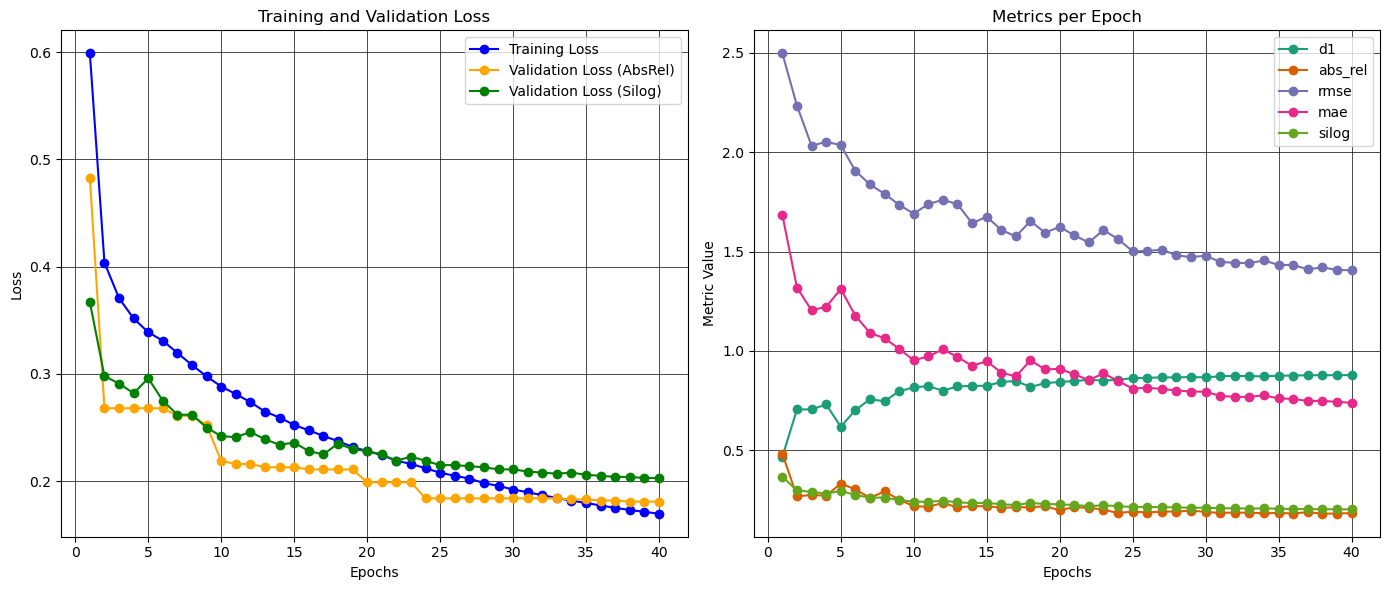

In [ ]:


# Read the CSV log file
csv_log = pd.read_csv(output_path)  

print(csv_log.head())
# Create a figure for training and validation loss
plt.figure(figsize=(14, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(csv_log['epoch'], csv_log['train_loss'], label='Training Loss', color='blue', marker='o')
plt.plot(csv_log['epoch'], csv_log['best_val_absrel'], label='Validation Loss (AbsRel)', color='orange', marker='o')
plt.plot(csv_log['epoch'], csv_log['silog'], label='Validation Loss (Silog)', color='green', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.5)

# Create a figure for metrics per epoch
metrics = ['d1', 'abs_rel', 'rmse', 'mae', 'silog']
colors = sns.color_palette("Dark2", len(metrics))  # Different colors for each metric

plt.subplot(1, 2, 2)
for i, metric in enumerate(metrics):
    plt.plot(csv_log['epoch'], csv_log[metric], label=metric, color=colors[i], marker='o')

plt.title('Metrics per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(color='black', linestyle='-', linewidth=0.5)

# Show the plots
plt.tight_layout()
plt.show()

## Inference on Polycam Data

In [ ]:
model = DepthAnythingV2(**{**model_configs[model_encoder], 'max_depth': max_depth}).to('cuda')
model.load_state_dict(torch.load(save_model_path))

/tmp/ipykernel_332964/2870507993.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))


<All keys matched successfully>